In [1]:
import pickle
import operator
import pandas as pd
import os
import numpy as np
from matplotlib import pyplot as plt 
from cv2 import cv2
import cv2
import math

import keras
from keras import *
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input, decode_predictions, VGG16
from keras.preprocessing import image as kimage
from keras.models import Sequential
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.optimizers import SGD
from keras.layers import Activation, LeakyReLU


import sklearn
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KDTree
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, LeaveOneOut
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

import pickle

import tensorflow as tf
from tensorflow.keras.activations import sigmoid
from tensorflow.keras import regularizers
from tensorflow.keras.applications import mobilenet_v2

from skimage.feature import hog

# Neural Network

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



In [ ]:
train_processing = keras.preprocessing.image.ImageDataGenerator(rotation_range=45, 
                                                                width_shift_range=0.1, 
                                                                height_shift_range=0.1, 
                                                                zoom_range=0.1, 
                                                                preprocessing_function=mobilenet_v2.preprocess_input)###resnet_v2 mobilenet_v2 vgg16
train_generator= train_processing.flow_from_directory( 
    directory='mask_NEW_train_folders',
    target_size=(224,224), #scelta standard
    color_mode= 'rgb', #dobbiamo mettere stessi parametri della rete di partenza
    class_mode = 'categorical',
    batch_size = 16,
    shuffle = True,
    seed = 1
)

In [ ]:
test_processing = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=mobilenet_v2.preprocess_input)###resnet_v2 mobilenet_v2 vgg16
test_generator= test_processing.flow_from_directory(
    directory='mask_NEW_test_folders',
    target_size=(224,224), #scelta standard
    color_mode= 'rgb', #dobbiamo mettere stessi parametri della rete di partenza
    class_mode = 'categorical',
    batch_size = 16,
    shuffle = True,
    seed = 1
)

In [ ]:
val_processing = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=mobilenet_v2.preprocess_input)###resnet_v2 mobilenet_v2 vgg16
val_generator= val_processing.flow_from_directory(
    directory='mask_NEW_val_folders',
    target_size=(224,224), #scelta standard
    color_mode= 'rgb', #dobbiamo mettere stessi parametri della rete di partenza
    class_mode = 'categorical',
    batch_size = 16,
    shuffle = True,
    seed = 1
)

In [ ]:
val_test_processing = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=mobilenet_v2.preprocess_input)###resnet_v2 mobilenet_v2 vgg16
val_test_generator = val_test_processing.flow_from_directory(
    directory='mask_NEW_val_test_folders',
    target_size=(224,224), #scelta standard
    color_mode= 'rgb', #dobbiamo mettere stessi parametri della rete di partenza
    class_mode = 'categorical',
    batch_size = 16,
    shuffle = True,
    seed = 1
)

In [ ]:
base_net = mobilenet_v2.MobileNetV2(input_shape=(224,224,3), weights ='imagenet', include_top=False, pooling='avg')

In [ ]:
base_net = resnet_v2.ResNet101V2(input_shape=(224,224,3), weights ='imagenet', include_top=False, pooling='avg')

In [ ]:
base_net = vgg16.VGG16(input_shape=(224,224,3), weights ='imagenet', include_top=False, pooling='avg')

In [ ]:
base_net = efficientnet.EfficientNetB0(include_top=False, weights='imagenet', pooling='avg', input_shape=(224,224,3))

In [ ]:
base_net.summary()

In [ ]:
for layers in base_net.layers:
    layers.trainable = False

In [ ]:
x = base_net.output #base_net.get_layer('fc1').output

x = keras.layers.BatchNormalization()(x)
x = keras.layers.ReLU()(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(128, activation = 'relu', kernel_regularizer=regularizers.l2(0.0005))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.5)(x)

pred = keras.layers.Dense(102, activation='softmax')(x) 


In [ ]:
net = keras.Model(inputs=base_net.input, outputs=pred)

In [ ]:
net.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.RMSprop(), #keras.optimizers.RMSprop() #keras.optimizers.Adam() #sgd
            metrics=['accuracy', f1_m])

In [ ]:
history = net.fit(train_generator, batch_size=64, epochs=30, verbose=1, validation_data=val_generator) ####30

In [ ]:
pred_test = net.evaluate(test_generator)
print(pred_test)
pred_val = net.evaluate(val_generator)
print(pred_val)

In [ ]:
net.save('mod3_100epochs_mobilenet.h5')

In [ ]:
x_plot = list(range(1,30+1))

def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(x_plot, network_history.history['loss'])
    plt.plot(x_plot, network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(x_plot, network_history.history['accuracy'])
    plt.plot(x_plot, network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()


In [ ]:
plot_history(history)

# SVM

In [ ]:
base_net = efficientnet.EfficientNetB0(include_top=False, weights='imagenet', pooling='avg', input_shape=(224,224,3))
def neural_features(image_path):
    img = kimage.load_img(image_path, target_size=(224, 224))
    x = kimage.img_to_array(img)
    x = mobilenet_v2.preprocess_input(x)
    x = np.expand_dims(x, axis = 0)
    features = net.predict(x) #features = feature_extractor1.predict(x) feature_extractor2.predict(x) net.predict(x) netvgg.predict(x) feature_extractor3.predict(x)
    features = features.flatten()   
    return features


def get_colors (image_path):
    img = cv2.imread(image_path)
    _, img = cv2.threshold(img, 150, 255, cv2.THRESH_BINARY)

    color = ('b','g','r')
    qtdBlue = 0
    qtdGreen = 0
    qtdRed = 0
    totalPixels = 0

    for channel,_ in enumerate(color):
        histr = cv2.calcHist([img],[channel],None,[256],[1,256])
        totalPixels+=sum(histr)
        if channel==0:
            qtdBlue = sum(histr)
        elif channel==1:
            qtdGreen = sum(histr)
        elif channel==2:
            qtdRed = sum(histr)

    qtdBlue = (qtdBlue/totalPixels)*100
    qtdGreen = (qtdGreen/totalPixels)*100
    qtdRed = (qtdRed/totalPixels)*100

    if math.isnan(qtdBlue) == True :
        qtdBlue = np.zeros(1)
    if math.isnan(qtdGreen) == True :
        qtdGreen = np.zeros(1)
    if math.isnan(qtdRed) == True :
        qtdRed = np.zeros(1)

    colors = np.asarray([qtdBlue[0], qtdGreen[0], qtdRed[0]])
    #colors = np.expand_dims(colors, axis = 0)
    return colors

def hog_image (image_path):
    image = kimage.load_img(image_path, target_size= (224,224))
    features, _ = hog(image, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True, multichannel=True)

    return features

def combo_neural_colors_hog(image_path):

    neural = neural_features (image_path)

    colors = get_colors(image_path)
    
    hog = hog_image (image_path)
    
    return np.concatenate((colors, neural, hog))

In [ ]:
def identity(image_path):
    img = kimage.load_img(image_path, target_size=(224, 224), color_mode= 'rgb')
    x = kimage.img_to_array(img)
    x = mobilenet_v2.preprocess_input(x)
    return x

# Data loader
def load_data(folder, feature_extractor=identity, maximages = 'default' ):
    if maximages == 'default':
        maximages = len(os.listdir(folder))+1

    base_path = folder

    features = []

    for index, image in enumerate(sorted(os.listdir(base_path))):
        print ('image', index)
        if index < maximages:
            image_path = base_path+image
            # Load file and extract features
            cur_features = feature_extractor(image_path)
            #cur_features = cur_features.flatten()
            features.append(cur_features)

    #features = np.array(features)
    return features

In [ ]:
X_train_features = load_data('mask_NEW_train/',feature_extractor=neural_features)
with open('X_train_features_neural.pickle', 'wb') as handle:
    pickle.dump(X_train_features, handle)
X_test_features = load_data(feature_extractor=neural_features, folder = 'mask_NEW_test/')
with open('X_test_features_neural.pickle', 'wb') as handle:
    pickle.dump(X_test_features, handle)
X_val_features = load_data(feature_extractor=neural_features, folder = 'mask_NEW_val/')
with open('X_val_features_neural.pickle', 'wb') as handle:
    pickle.dump(X_val_features, handle)
X_train_val_features = load_data(feature_extractor=combo_neural_colors_hog, folder = 'mask_NEW_val_train/')
with open('X_train_val_features_neural_colors_hog.pickle', 'wb') as handle:
    pickle.dump(X_train_val_features, handle)

In [ ]:
with open ('102flowers_y_train.pickle', 'rb') as handle:
    y_train = pickle.load(handle)
num_classes = 102
yc_train = keras.utils.to_categorical(y_train-1, num_classes)
with open ('102flowers_y_test.pickle', 'rb') as handle:
    y_test = pickle.load(handle)
num_classes = 102
yc_test = keras.utils.to_categorical(y_test-1, num_classes)
with open ('102flowers_y_val.pickle', 'rb') as handle:
    y_val = pickle.load(handle)
num_classes = 102
yc_val = keras.utils.to_categorical(y_val-1, num_classes)
with open ('102flowers_y_train_val.pickle', 'rb') as handle:
    y_train_val = pickle.load(handle)
num_classes = 102
yc_train_val = keras.utils.to_categorical(y_train_val-1, num_classes)

In [ ]:
with open('X_test_features_neural_colors_hog.pickle', 'rb') as handle:
    X_test_features = pickle.load(handle)
with open('X_train_features_neural_colors_hog.pickle', 'rb') as handle:
    X_train_features = pickle.load(handle)
with open('X_val_features_neural_colors_hog.pickle', 'rb') as handle:
    X_val_features = pickle.load(handle)
with open('X_train_val_features_neural_colors_hog.pickle', 'rb') as handle:
    X_train_val_features = pickle.load(handle)

In [ ]:
clf2 = SVC(kernel='poly', class_weight='balanced', C = 1e2, gamma = 'auto')
print('fit...')
clf2=clf2.fit(X_train_features, y_train)
print('predict...')
y2_pred = clf2.predict(X_train_features)
#print(classification_report(y_test, y2_pred))

print('performing cross-validation...')
#calculate cross validated (leave one out) accuracy score
scores = cross_val_score(clf2, X_train_features, y_train, cv = 5, scoring='accuracy')

print( scores.mean() )

In [ ]:
with open('svc_sutest_neural_colors_hog_nooverfitting.pickle', 'wb') as handle:
    pickle.dump(clf2, handle)

In [ ]:
with open('svc_sutest_neural_colors_hog_nooverfitting.pickle', 'rb') as handle:
    clf2 = pickle.load(handle)

In [ ]:
y2_pred = clf2.predict(X_train_features)
#print(classification_report(y_test, y2_pred))

print('performing cross-validation...')
#calculate cross validated (leave one out) accuracy score
scores = cross_val_score(clf2, X_train_features, y_train, cv = 5, scoring='accuracy')
print( scores.mean() )

In [ ]:
y_pred_test_val = clf2.predict(X_test_val_features)
print(classification_report(y_test_val, y_pred_test_val))

In [ ]:
print(sklearn.metrics.f1_score(y_test_val, y_pred_test_val, average='weighted'))

In [ ]:
cm=confusion_matrix(y_test_val, y_pred_test_val) 
plt.imshow(cm, cmap=plt.cm.Blues)

# PROVA PERFORMANCE

In [25]:
NAMES = [
    "pink primrose", "hard-leaved pocket orchid", "canterbury bells",
    "sweet pea", "english marigold", "tiger lily", "moon orchid",
    "bird of paradise", "monkshood", "globe thistle", "snapdragon",
    "colt's foot", "king protea", "spear thistle", "yellow iris",
    "globe-flower", "purple coneflower", "peruvian lily", "balloon flower",
    "giant white arum lily", "fire lily", "pincushion flower", "fritillary",
    "red ginger", "grape hyacinth", "corn poppy", "prince of wales feathers",
    "stemless gentian", "artichoke", "sweet william", "carnation",
    "garden phlox", "love in the mist", "mexican aster", "alpine sea holly",
    "ruby-lipped cattleya", "cape flower", "great masterwort", "siam tulip",
    "lenten rose", "barbeton daisy", "daffodil", "sword lily", "poinsettia",
    "bolero deep blue", "wallflower", "marigold", "buttercup", "oxeye daisy",
    "common dandelion", "petunia", "wild pansy", "primula", "sunflower",
    "pelargonium", "bishop of llandaff", "gaura", "geranium", "orange dahlia",
    "pink-yellow dahlia?", "cautleya spicata", "japanese anemone",
    "black-eyed susan", "silverbush", "californian poppy", "osteospermum",
    "spring crocus", "bearded iris", "windflower", "tree poppy", "gazania",
    "azalea", "water lily", "rose", "thorn apple", "morning glory",
    "passion flower", "lotus", "toad lily", "anthurium", "frangipani",
    "clematis", "hibiscus", "columbine", "desert-rose", "tree mallow",
    "magnolia", "cyclamen", "watercress", "canna lily", "hippeastrum",
    "bee balm", "ball moss", "foxglove", "bougainvillea", "camellia", "mallow",
    "mexican petunia", "bromelia", "blanket flower", "trumpet creeper",
    "blackberry lily"
]


In [2]:
categories = {}
listimages = sorted(os.listdir('categories'))
for i in range(len(NAMES)):
    categories[NAMES[i]] = 'categories/' + listimages[i]

In [28]:
net = None
net=keras.models.load_model('mod3_100epochs_mobilenet.h5')

In [5]:
def predict_name(image_path, classifier):
    img = kimage.load_img(image_path)
    x = kimage.img_to_array(img)
    x = mobilenet_v2.preprocess_input(x)
    x = np.expand_dims(x, axis = 0)

    prediction = classifier.predict(x)

    return prediction[0], img

In [15]:
def predict_name_photo (image_path, classifier):

    
    NAMES.sort()


    prediction, image = predict_name(image_path, classifier)
    prediction_name = NAMES[np.argmax(prediction)]
    print(np.argmax(prediction))
    print(prediction_name)

    path_pred_image = categories[prediction_name]
    image_pred = cv2.imread(path_pred_image)
    image_pred = cv2.cvtColor(image_pred, cv2.COLOR_BGR2RGB)


    plt.subplot(1,2,1),plt.imshow(image), plt.title('What is it?')
    plt.subplot(1,2,2),plt.imshow(image_pred), plt.title(prediction_name)

    #return NAMES[prediction-1]

In [26]:
NAMES[67]

'bearded iris'

66
0


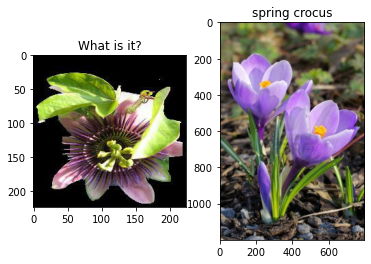

In [27]:
predict_name_photo('mask_NEW/image_00003.jpg', net)

In [ ]:
predict_name_photo('mask_NEW/image_06971.jpg', net)